In [97]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

sampling_frequency = 96000


def to_fixed_8_24(value: np.float32 | float) -> np.float32:

     # simulate the floatToFixed8_24 operation from the firmware

    if (value < -128.0):
        value = -128.0
    if (value > 127.999984):
        value = 127.999984
    fixed_value = np.zeros_like(0,shape = 1,dtype=np.int32)
    power = np.int32(np.power(2, 24)) 

    fixed_value = np.int32(value * power)
    return np.float32(fixed_value/power)           # back to float32 -> next functions needs floats


def calculate_filter_coef(frequency,gain, q, samplingFrequency):


    # calculate with double precision like the esp32
    omega = ((2 * np.pi * frequency) / samplingFrequency) # Normalized frequency
    A = np.pow(10, (gain) / 40);               #Convert gain from dB to linear scale
    alpha = (np.sin(omega)) / (2 * q);         #Calculate alpha for the filter design

    b0 = 1 + alpha * A
    b1 = -2 * np.cos(omega)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * np.cos(omega)
    a2 = 1 - alpha / A
    

    coefficients =  np.array([b0,b1,b2,a0,a1,a2])

    coefficient_norm = coefficients /a0

    coefficient_after_8_24 = np.zeros(6)

    # send it in Q8.24 format 
    for i, coefficient in enumerate (coefficient_norm,start=0):
          coefficient_after_8_24[i] = to_fixed_8_24(coefficient)
          
    return coefficient_after_8_24 ,frequency,gain, q

Filter1_coeficient_freq_gain_q= calculate_filter_coef(100,-5,10,sampling_frequency)

Filter2_coeficient_freq_gain_q= calculate_filter_coef(500,-5,10,sampling_frequency)

Filter3_coeficient_freq_gain_q= calculate_filter_coef(2000,-5,10,sampling_frequency)

Filter4_coeficient_freq_gain_q= calculate_filter_coef(10000,-5,10,sampling_frequency)

filter_all = [Filter1_coeficient_freq_gain_q, Filter2_coeficient_freq_gain_q, Filter3_coeficient_freq_gain_q, Filter4_coeficient_freq_gain_q]

display(filter_all[0][0])


array([ 0.99980909, -1.99908471,  0.99931848,  1.        , -1.99908471,
        0.99912757])

In [98]:
# calculate the frequency response
results_all = []
for filter in filter_all:
    w, h = signal.freqz_sos(filter[0], worN=512*20)
    results_all.append((w, h))


# create an array for h (complex frequency response --> transfer function H(w)) filled with ones --> an emty array for a multiplikation
h_total = np.ones_like(results_all[0][1]) 


# put alle filter in serial: (Y(w) = X(w)*H1(w)*H2(w)*H3(w)*H4(w))
for _, h in results_all:
      h_total *= h 




'Filter 1: Input: Frequenz (Hz): 100, Gain (dB): -5, Q: 10,  b0, b1, b2, a0, ,a1, a2: [ 0.99980909 -1.99908471  0.99931848  1.         -1.99908471  0.99912757]'

'Filter 2: Input: Frequenz (Hz): 500, Gain (dB): -5, Q: 10,  b0, b1, b2, a0, ,a1, a2: [ 0.99904728 -1.99457788  0.99659902  1.         -1.99457788  0.9956463 ]'

'Filter 3: Input: Frequenz (Hz): 2000, Gain (dB): -5, Q: 10,  b0, b1, b2, a0, ,a1, a2: [ 0.99622393 -1.96578157  0.98652029  1.         -1.96578157  0.98274422]'

'Filter 4: Input: Frequenz (Hz): 10000, Gain (dB): -5, Q: 10,  b0, b1, b2, a0, ,a1, a2: [ 0.9829284  -1.52481461  0.93905842  1.         -1.52481461  0.92198688]'

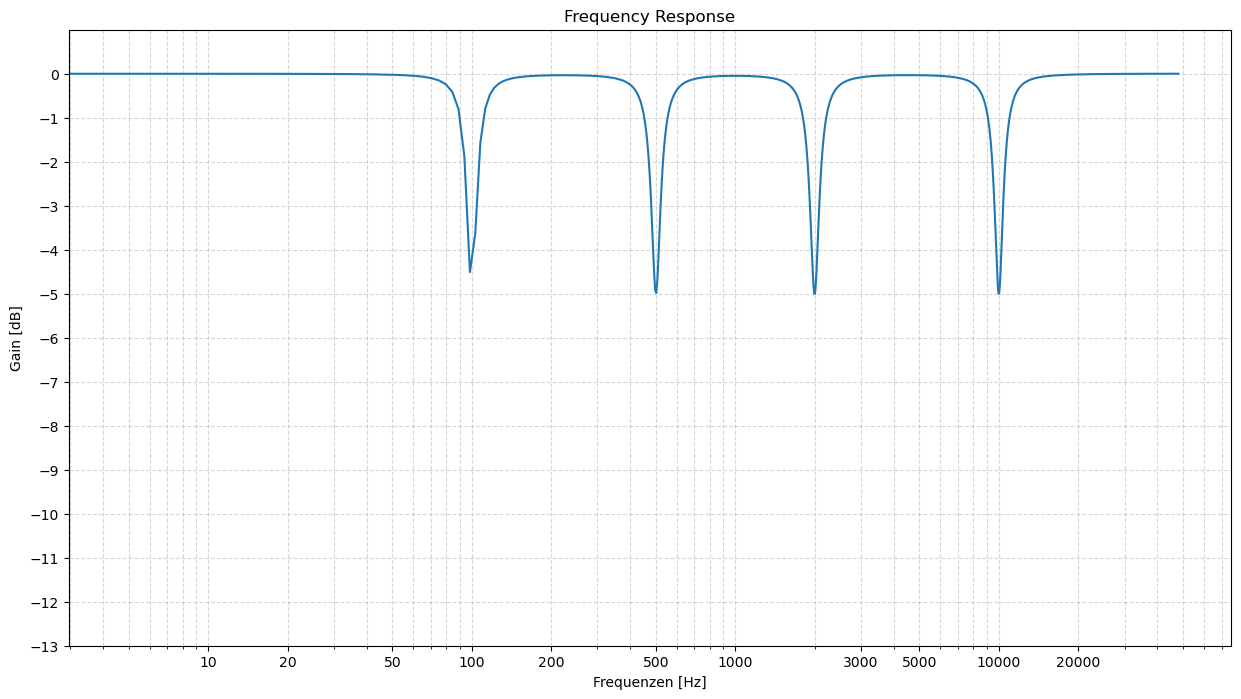

In [99]:
import matplotlib.pyplot as plt


# plot the frequency response use np.maximum an the absolute values from h_total (magnitude), get rid of small values (noise)

db = 20*np.log10(np.maximum(np.abs(h_total), 1e-5))
# calculate the frequencies from w 
frequencies = ((w/np.pi)/2)*sampling_frequency

#set plot settings
plt.figure(figsize=(15, 8)) 
plt.title('Frequency Response')
plt.grid(which='both', linestyle='--', alpha=0.5)

# x-Axis
plt.xscale('log') 
x_ticks = [10, 20, 50, 100, 200, 500, 1000,3000, 5000, 10000,20000]
plt.xticks(x_ticks, [str(t) for t in x_ticks])  
plt.xlabel('Frequenzen [Hz]')

# y-Axis
plt.ylim(-13,1)
y_tickes = np.arange(-13,1,1)
plt.yticks(y_tickes)
plt.ylabel('Gain [dB]')

plt.plot(frequencies, db)


for i, filter in enumerate(filter_all, start=1):
    display(f"Filter {i}: Input: Frequenz (Hz): {filter [1]}, Gain (dB): {filter [2]}, Q: {filter [3]},  b0, b1, b2, a0, ,a1, a2: {filter [0]}")
